### first pass on API for ASE OOS

use cases:
- low/high degree nodes tend to distord spectral embedding, so omit from original embedding and then add back in with oos
- original graph too big, so make a subgraph and embed, then do oos for the rest
- have graph, embed it, get new graph defined on a larger set of nodes but with the same relationship between vertices. embed new graph with oos because it's generated by the same underlying distribution.

### notes
- add sklearn's exceptions.NotFittedError if we try to predict without fitting?
- for class-based sklearnish APIs, could add an augment_latent_positions toggle to predict if we want to have predicting update the latent positions matrix
- [partial-fit](https://scikit-learn.org/stable/glossary.html#term-partial-fit) could be useful if we want an API for updating our latent positions matrix with oos data?
- sklearn.utils.estimator_checks.check_estimator useful if I want to use the sklearn api
- sklearn.utils.check_array useful for input validation

In [295]:
import numpy as np
from scipy.linalg import orthogonal_procrustes
from sklearn.utils.validation import check_is_fitted

from sklearn.metrics.pairwise import euclidean_distances
from tqdm.notebook import tqdm

from graspy.simulations import sbm
from graspy.embed.base import BaseEmbed
from graspy.plot import heatmap

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 120

In [2]:
# API 1: we just have an OOSEmbedder class
class OOSEmbed(BaseEmbed):
    def __init__(self, Xhat=None):
        # maybe some useful toggles on behavior here?
        self.X_ = Xhat  # TODO: can pass in a precomputed ASE if you want,
                        # in which case `fit` will just use that as its X value.
                        # need some way to get eigenvalues if you pass in precomputed ASE
        pass
    
    def fit(self, X=None, y=None):
        """
        would take some input adjacency matrix X,
        embed it, and add self.pinv_, self.latent_right_,
        and self.singular_values_ to class attributes
        """
        # X \in R^{nxn}. if X is None, use `self.X`. If `self.X` is None, raise an error.
        
        # some code to make self.pinv,
        # input-validation
        # and maybe error checking, etc
        # returns self
        
        # checks on X go here, then
        # grab pinv and make new class attributes
        
        # TODO: break if X is None and self.X_ is None
        
        if self.X_ is None:
            ase = AdjacencySpectralEmbed(n_components=2)  # need some way to change parameters
            ase.fit(X)
            self.X_ = ase.latent_left_.copy()
            self.eig_values_ = ase.singular_values_.copy()
            
        self.pinv_ = self.X_ @ np.diag(1/self.eig_values_)
        
        self.is_fitted_ = True
        
        # add self.X_ \in R^{nxd}, the latent position matrix
        pass


    def predict(self, y):
        """
        Given some latent position matrix X,
        its diagonal eigenvalue matrix D,
        and edge matrix y,
        compute the least-squares estimate for the latent position of y.

        Parameters
        ----------
        y: array
            out-of-sample vectors to embed. nxd
        """
        check_is_fitted(self, 'is_fitted_')
        # input validation
        return y @ self.pinv_
        # maybe toggle for returning either 
        # *just* oos latent positions,
        # or an augmented ASE?

In [297]:
# API 2: we augment the AdjacencySpectralEmbed class with
# a predict method. This was Hayden's idea in the
# issue
from graspy.utils import (
    import_graph,
    is_fully_connected,
    augment_diagonal,
    pass_to_ranks,
    is_unweighted,
)
class AdjacencySpectralEmbed(BaseEmbed):
    r"""
    bla bla bla
    """

    def __init__(
        self,
        n_components=None,
        n_elbows=2,
        algorithm="randomized",
        n_iter=5,
        check_lcc=True,
        diag_aug=True,
    ):
        super().__init__(
            n_components=n_components,
            n_elbows=n_elbows,
            algorithm=algorithm,
            n_iter=n_iter,
            check_lcc=check_lcc,
        )

        if not isinstance(diag_aug, bool):
            raise TypeError("`diag_aug` must be of type bool")
        self.diag_aug = diag_aug

    def fit(self, graph, y=None):
        # would add the pseudoinverse
        # as a class attribute in fit
        """
        bla bla bla
        """
        A = import_graph(graph)

        if self.check_lcc:
            if not is_fully_connected(A):
                msg = (
                    "Input graph is not fully connected. Results may not"
                    + "be optimal. You can compute the largest connected component by"
                    + "using ``graspy.utils.get_lcc``."
                )
                warnings.warn(msg, UserWarning)

        if self.diag_aug:
            A = augment_diagonal(A)

        self._reduce_dim(A)
        self.is_fitted_ = True
        return self
    
    def predict(self, y):
        check_is_fitted(self, 'is_fitted_')
        self.pinv_ = self.latent_left_ @ (np.diag(1/self.singular_values_))
        return y @ self.pinv_

### check true latent position compared to oos embedding as n increases (using OOSEmbed class)

#### make matrix

In [4]:

p = .5
# distances = {}
# for n in tqdm(range(10, 1000, 10)):
#     M = er_np(n=n, p=p)

#     # separate
#     A = M[:-1, :-1]
#     a = M[-1, :-1]

#     # true latent positions
#     ase = AdjacencySpectralEmbed(n_components=2)
#     true = ase.fit_transform(M)[-1]

#     # predicted latent positions
#     oos = OOSEmbed()
#     oos.fit(A)
#     predicted = oos.predict(a)

#     as_ = np.row_stack((true, predicted))
#     distance = euclidean_distances(as_)[0, 1]
#     distances[n] = distance

In [ ]:
distances

In [ ]:
# # distances = sorted(distances.items()) # sorted by key, return a list of tuples
# x, y = zip(*distances) # unpack a list of pairs into two tuples
# #
# # ended up being a shitty graph that doesn't say much
# plt.scatter(x, y)
# plt.title("Graph size vs pairwise distance between predicted and true latent positions");
# plt.xlabel("Graph size (nodes)");
# plt.ylabel("Pairwise distance");
# plt.savefig("../figs/pairwise_distances.png", dpi=600)

### Start trying to reproduce figure 1

![Figure 1](../figs/figure1_original.png)

Empirical distribution of the LLS OOS estimate for 100 independent trials for number of vertices n = 50 (left), n = 100 (middle) and n = 500 (right). Each plot shows the positions of 100 independent OOS embeddings, indicated by crosses, and colored according to cluster membership. Contours indicate two generalized standard deviations of the multi- variate normal (i.e., 68% and 95% of the probability mass) about the true latent positions, which are indicated by solid circles. We note that even with merely 100 vertices, the normal approximation is already quite reasonable.

1. consider $F = \lambda \delta_{x1} + (1-\lambda)\delta_{x2}$, with $x_1, x_2 \in \textbf{R}^2$.

In [217]:
λ = np.array([0.4, 1-.4])
n = 5
x1 = np.array([.2, .7])
x2 = np.array([.65, .3])

latents = np.vstack((x1, x2))
latents = np.repeat(latents, n, axis=0)

# index out oos
p = np.repeat(λ, n) / n
np.random.choice(10, p=p)

1.0

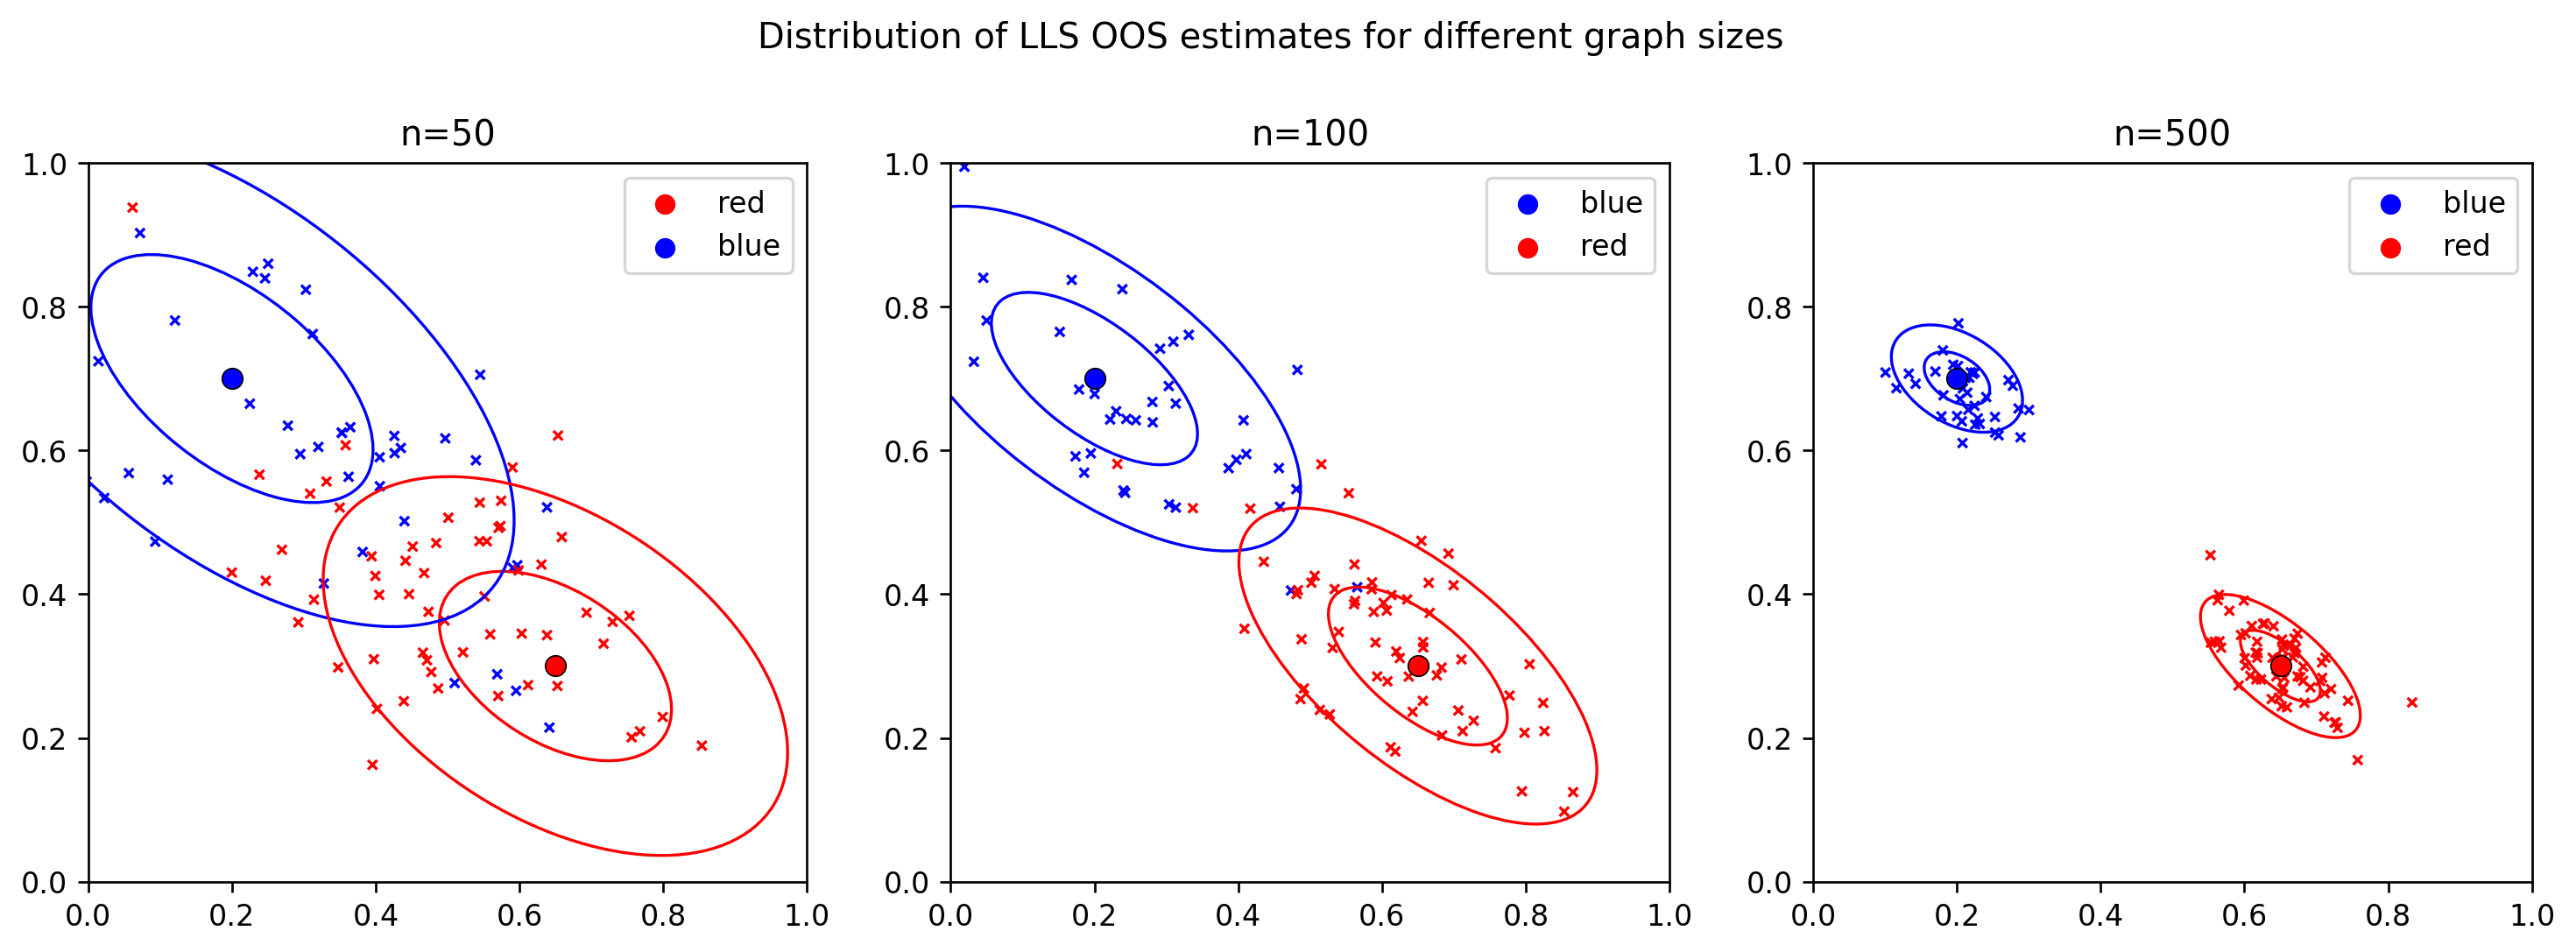

In [380]:
from graspy.simulations import rdpg, sbm
from graspy.plot import pairplot
import pandas as pd
import seaborn as sns

# generate M from rdpg,
# grab true latent positions

def confidence_ellipse(data, ax, mean=None, n_std=3.0, facecolor='none', **kwargs):
    """
    make confidence ellipse for plot
    """
    x, y = data[:, 0], data[:, 1]
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    if mean is None:
        mean_x = np.mean(x)
    else:
        mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    if mean is None:
        mean_y = np.mean(y)
    else:
        mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def trial(n):
    # known parameters
    labels = ["blue"]*n + ["red"]*n
    lamb = np.array([0.4, 1-.4])
    x1 = np.array([.2, .7])
    x2 = np.array([.65, .3])
    latents = np.vstack((x1, x2))
    
    # generate latent positions
    latents = np.repeat(latents, n, axis=0)

    # generate M from rdpg
    M = rdpg(latents)

    # index out oos
    p = np.repeat(lamb, n) / n
    i = np.random.choice(n*2, p=p)
    label = labels[i]
    a = M[i, :]
    a = np.delete(a, i)
    A = np.delete(M, i, 0)
    A = np.delete(A, i, 1)
    latents_ = np.delete(latents, i, 0)

    # embed without oos stuff
    ase = AdjacencySpectralEmbed(n_components=2)
    ase.fit(A)

    # Procrustes alignment
    R, _ = orthogonal_procrustes(ase.latent_left_, latents_)

    # predict oos
    w = ase.predict(a)
    w = w @ R

    return w, label

# run 100 trials and plot
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, n_ in enumerate([50, 100, 500]):
    n = n_ // 2
    ws = []
    labels = []
    for _ in tqdm(range(100)):
        w, label = trial(n)
        ws.append(list(w))
        labels.append(label)

    ws = np.array(ws)
    labels = np.array(labels)
    x, y = ws[:, 0], ws[:, 1]

    # separate labels and set parameters
    blues = ws[labels == 'blue']
    reds = ws[labels == 'red']
    mu_b = np.array([.2, .7])
    mu_r = np.array([.65, .3])

    # plot
    sns.scatterplot(x, y, ax=axes[i], hue=labels, palette={'red': 'r', 'blue': 'b'}, marker='x', linewidth=1, s=10)
    axes[i].scatter(x1[0], x1[1], marker='o', c='b', s=50, edgecolors='k', linewidth=.5)  # didn't work
    axes[i].scatter(x2[0], x2[1], marker='o', c='r', s=50, edgecolors='k', linewidth=.5)
    for std in range(1, 3):
        confidence_ellipse(blues, ax=axes[i], mean=mu_b, n_std=std, edgecolor='b')
        confidence_ellipse(reds, ax=axes[i], mean=mu_r, n_std=std, edgecolor='r')
    
    # make sure aspects are correct
    axes[i].set_aspect('equal')
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    
    # title
    axes[i].set_title(f'n={n_}')
    
fig.suptitle("Distribution of LLS OOS estimates for different graph sizes");
plt.savefig("../figs/oos_estimates_distribution.png", dpi=600)